## Predicting Pectin extraction yield from FTIR ($X_1$) and Carbohydrate Microarray ($X_2$) data

In this example we use Multiblock Partial Least Squares regression to predict the pectin extraction yield for samples which were measured on FTIR and Carbohydrate Microarrays. The aim is not only to establish prediction models, but also to investigate how much each block contributes to the prediction of the extraction yield.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mbpls.data.get_data import load_Intro_Data
from scipy.io import loadmat

In [2]:
data = load_Intro_Data()

Following dataset were loaded as Pandas Dataframes:  dict_keys(['extraction3', 'ftir1', 'extraction2', 'ftir2', 'ftir3', 'extraction1'])


In [3]:
ftir1 = data['ftir1']
ftir2 = data['ftir2']
ftir3 = data['ftir3']
carb1 = data['extraction1']
carb2 = data['extraction2']
carb3 = data['extraction3']

In [4]:
ftir = pd.concat((ftir1, ftir2, ftir3))
extractions = pd.concat((carb1, carb2, carb3))
extractions.index = ftir.index
yield_all = np.array(extractions.index)
data = pd.concat((ftir, extractions), axis=1)

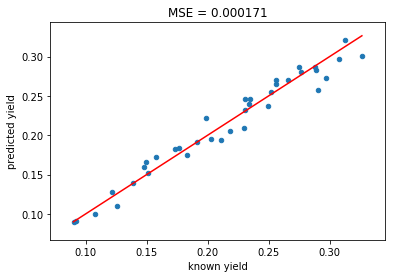

In [5]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

mbpls = MBPLS(n_components=3)
prediction = cross_val_predict(mbpls, data, yield_all, cv=len(ftir))
prediction = pd.DataFrame(prediction)
yield_all = pd.DataFrame(yield_all)
prediction = pd.concat((prediction, yield_all), axis=1)
prediction.columns=['predicted yield', 'known yield']
prediction.plot.scatter(x='known yield', y='predicted yield')
plt.plot([prediction.min().min(), prediction.max().max()], [prediction.min().min(), prediction.max().max()], color='red')
plt.title('MSE = %.6f' % mean_squared_error(prediction['known yield'], prediction['predicted yield']));

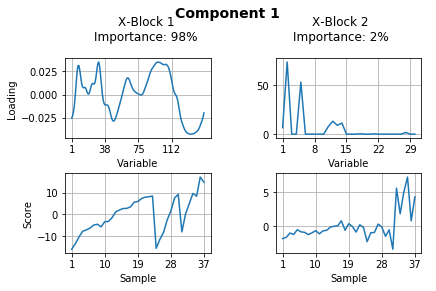

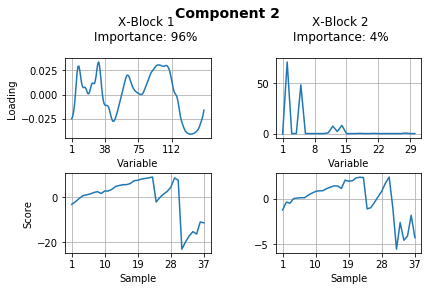

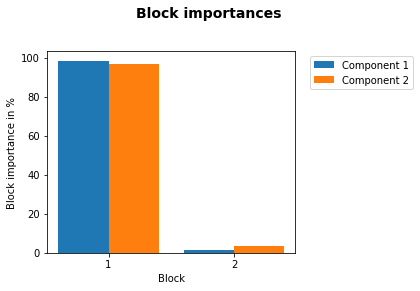

In [6]:
mbpls = MBPLS(n_components=2)
mbpls.fit_transform(X=[ftir, extractions], y=yield_all)
mbpls.plot(num_components=2)

In [7]:
print('The corrected Block Importances in each latent variable are:')
BIP_corrected = pd.DataFrame(mbpls.A_corrected_.round(2), columns=['LV1', 'LV2'], index=['FTIR', 'Carb Micr Array'])
BIP_corrected

The corrected Block Importances in each latent variable are:


,LV1,LV2
FTIR,0.92,0.85
Carb Micr Array,0.08,0.15
